In [1]:
# A simple notebook demonstrating how to fine-tune a DinoV2 classifier on your own images/labels

# Most of the core code was originally published in an excellent tutorial by Kili Technology, here:
#  https://colab.research.google.com/github/kili-technology/kili-python-sdk/blob/main/recipes/finetuning_dinov2.ipynb

# November 11th, 2023 by Lance Legel (lance@3co.ai) from 3co, Inc. (https://3co.ai)

import os
import random
import zipfile
from copy import deepcopy
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch import nn, optim
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from torchvision import datasets, transforms
from dinov2.models.vision_transformer import vit_small, vit_base, vit_large, vit_giant2

In [2]:
local_directory = os.getcwd()
train_dataset_dir = Path("../../data/train") # in "train", put a folder for each class, with folder name = class name
valid_dataset_dir = Path("../../data/val")   # in "val", same as above

In [3]:
# These are settings for ensuring input images to DinoV2 are properly sized

class ResizeAndPad:
    def __init__(self, target_size, multiple):
        self.target_size = target_size
        self.multiple = multiple

    def __call__(self, img):
        # Resize the image
        img = transforms.Resize(self.target_size)(img)

        # Calculate padding
        pad_width = (self.multiple - img.width % self.multiple) % self.multiple
        pad_height = (self.multiple - img.height % self.multiple) % self.multiple

        # Apply padding
        img = transforms.Pad((pad_width // 2, pad_height // 2, pad_width - pad_width // 2, pad_height - pad_height // 2))(img)
        
        return img

image_dimension = 256
    
# This is what DinoV2 sees
target_size = (image_dimension, image_dimension)

# Below are functions that every image will be passed through, including data augmentations
data_transforms = {
    "train": transforms.Compose(
        [
            ResizeAndPad(target_size, 14),
            transforms.RandomRotation(360),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

# Here is where we wrap up our images, which are in folders (defined above) where the folder name is class name
# As long as you defined the "train" folder above with sub-folders for each class, below will "just work"
image_datasets = {
    "train": datasets.ImageFolder(train_dataset_dir, data_transforms["train"])
}

dataloaders = {
    "train": torch.utils.data.DataLoader(image_datasets["train"], batch_size=8, shuffle=True)
}

class_names = image_datasets["train"].classes

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
# Define a new classifier layer that contains a few linear layers with a ReLU to make predictions positive
class DinoVisionTransformerClassifier(nn.Module):
    
    def __init__(self, model_size="small"):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.model_size = model_size
        
        # loading a model with registers
        n_register_tokens = 4
        
        if model_size == "small":        
            model = vit_small(patch_size=14,
                              img_size=526,
                              init_values=1.0,
                              num_register_tokens=n_register_tokens,
                              block_chunks=0)
            self.embedding_size = 384
            self.number_of_heads = 6
            
        elif model_size == "base":
            model = vit_base(patch_size=14,
                             img_size=526,
                             init_values=1.0,
                             num_register_tokens=n_register_tokens,
                             block_chunks=0)
            self.embedding_size = 768
            self.number_of_heads = 12

        elif model_size == "large":
            model = vit_large(patch_size=14,
                              img_size=526,
                              init_values=1.0,
                              num_register_tokens=n_register_tokens,
                              block_chunks=0)
            self.embedding_size = 1024
            self.number_of_heads = 16
            
        elif model_size == "giant":
            model = vit_giant2(patch_size=14,
                               img_size=526,
                               init_values=1.0,
                               num_register_tokens=n_register_tokens,
                               block_chunks=0)
            self.embedding_size = 1536
            self.number_of_heads = 24
        
        # Download pre-trained weights and place locally as-needed:
        # - small: https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_reg4_pretrain.pth
        # - base:  https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_reg4_pretrain.pth 
        # - large: https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_reg4_pretrain.pth
        # - giant: https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_reg4_pretrain.pth
        model.load_state_dict(torch.load(Path('{}/../dinov2_vits14_reg4_pretrain.pth'.format(local_directory))))

        self.transformer = deepcopy(model)

        self.classifier = nn.Sequential(nn.Linear(self.embedding_size, 256), nn.ReLU(), nn.Linear(256, 1))

    def forward(self, x):
        x = self.transformer(x)
        x = self.transformer.norm(x)
        x = self.classifier(x)
        return x

model = DinoVisionTransformerClassifier("small")

In [6]:
model = model.to(device)
model = model.train()

In [7]:
# change the binary cross-entropy loss below to a different loss if using more than 2 classes 
# https://pytorch.org/docs/stable/nn.html#loss-functions

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-6)

In [8]:
num_epochs = 50

In [9]:
def calculate_accuracy(outputs, labels):
    # Convert outputs to probabilities using sigmoid
    probabilities = torch.sigmoid(outputs)
    # Convert probabilities to predicted classes
    predicted_classes = probabilities > 0.5
    # Calculate accuracy
    correct_predictions = (predicted_classes == labels.byte()).sum().item()
    total_predictions = labels.size(0)
    return correct_predictions / total_predictions

epoch_losses = []
epoch_accuracies = []

print("Training...")
for epoch in range(num_epochs):
    batch_losses = []
    batch_accuracies = []

    for data in dataloaders["train"]:
        # get the input batch and the labels
        batch_of_images, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # model prediction
        output = model(batch_of_images.to(device)).squeeze(dim=1)

        # compute loss and do gradient descent
        loss = criterion(output, labels.float().to(device))

        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())
        
        # Calculate and record batch accuracy
        accuracy = calculate_accuracy(output, labels.to(device))
        batch_accuracies.append(accuracy)

    epoch_losses.append(np.mean(batch_losses))
    epoch_accuracy = np.mean(batch_accuracies)
    epoch_accuracies.append(epoch_accuracy)

    print("  -> Epoch {}: Loss = {:.5f}, Accuracy = {:.3f}%".format(epoch, epoch_losses[-1], 100*epoch_accuracy))

Training...
  -> Epoch 0: Loss = 0.63102, Accuracy = 68.333%
  -> Epoch 1: Loss = 0.45198, Accuracy = 84.810%
  -> Epoch 2: Loss = 0.32826, Accuracy = 88.976%
  -> Epoch 3: Loss = 0.24761, Accuracy = 92.952%
  -> Epoch 4: Loss = 0.22640, Accuracy = 92.333%
  -> Epoch 5: Loss = 0.20362, Accuracy = 92.000%
  -> Epoch 6: Loss = 0.19412, Accuracy = 92.000%
  -> Epoch 7: Loss = 0.18073, Accuracy = 93.810%
  -> Epoch 8: Loss = 0.16173, Accuracy = 93.476%
  -> Epoch 9: Loss = 0.13957, Accuracy = 95.167%
  -> Epoch 10: Loss = 0.13907, Accuracy = 94.976%
  -> Epoch 11: Loss = 0.13051, Accuracy = 95.333%
  -> Epoch 12: Loss = 0.11489, Accuracy = 96.000%
  -> Epoch 13: Loss = 0.11235, Accuracy = 96.333%
  -> Epoch 14: Loss = 0.10240, Accuracy = 97.167%
  -> Epoch 15: Loss = 0.08599, Accuracy = 97.143%
  -> Epoch 16: Loss = 0.09041, Accuracy = 96.500%
  -> Epoch 17: Loss = 0.08016, Accuracy = 97.667%
  -> Epoch 18: Loss = 0.08838, Accuracy = 96.833%
  -> Epoch 19: Loss = 0.07331, Accuracy = 97.167

Text(0, 0.5, 'Loss')

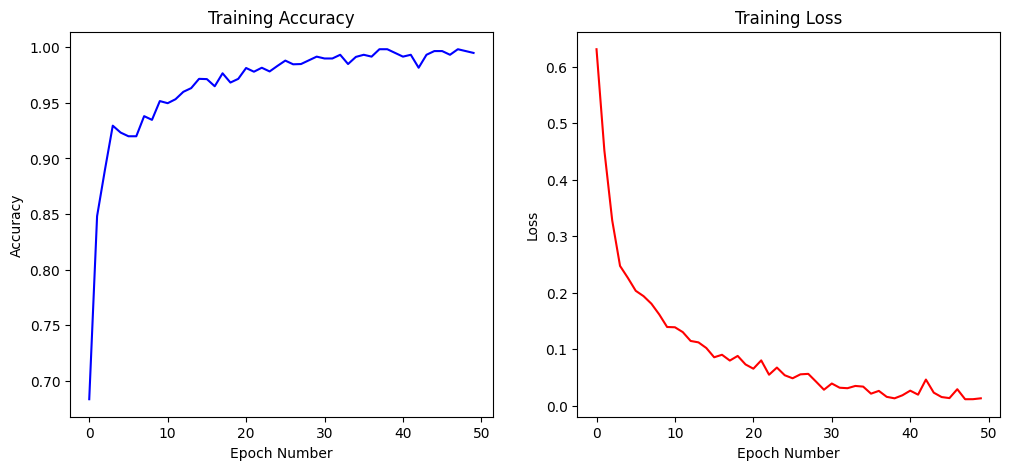

In [12]:
# Plotting accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epoch_accuracies, label='Accuracy', color='blue')
plt.title("Training Accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epoch_losses, label='Loss', color='red')
plt.title("Training Loss")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")

In [20]:
# During inference / testing / deployment, we want to remove data augmentations from the input transform:
inference_preprocessing = transforms.Compose([ ResizeAndPad(target_size, 14),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                             ]
                                            )

In [25]:
def inference_on_validation_data(inference_model, n_test_images=1):

    for class_name in class_names:
        # gather N validation images per class
        val_class_dir = "{}/{}".format(valid_dataset_dir, class_name)
        val_test_images = os.listdir(val_class_dir)[:n_test_images]

        for val_test_image in val_test_images:

            if ".jpg" not in val_test_image and ".png" not in val_test_image:
                continue

            # load image
            img = Image.open("{}/{}".format(val_class_dir, val_test_image))

            # pre-process image and load onto device
            img_tensor = inference_preprocessing(img)
            img_tensor = img_tensor.unsqueeze(0)
            input_tensor = img_tensor.to(device)

            # run model on input image data
            with torch.no_grad():
                embeddings = inference_model.transformer(input_tensor)
                x = inference_model.transformer.norm(embeddings)
                output_tensor = inference_model.classifier(x)

                # sigmoid
                score = output_tensor[0][0].item()
                score = 1 / (1 + np.exp(-score)) 

                # for binary classification, we can just interpret class name based on the 1 output score
                predicted_class = class_names[1] if score > 0.5 else class_names[0]

                print("\n\n\nDinoV2 Predicted = {} vs. Ground Truth = {}:".format(predicted_class, class_name))
                plt.imshow(img) 
                plt.show()

In [17]:
# save the model
torch.save(model.state_dict(), '{}/classifier.pth'.format(local_directory))

In [18]:
# reloading the model with trained classification weights to demonstrate deployment
classifier = DinoVisionTransformerClassifier("small")

classifier.load_state_dict(torch.load('{}/classifier.pth'.format(local_directory)))

classifier = classifier.to(device)
classifier.eval()

DinoVisionTransformerClassifier(
  (transformer): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, in




DinoV2 Predicted = garden vs. Ground Truth = garden:


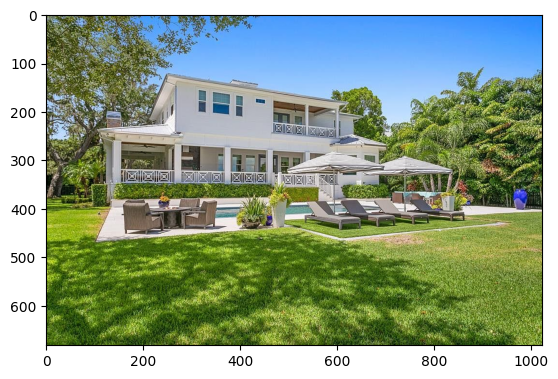




DinoV2 Predicted = not_garden vs. Ground Truth = not_garden:


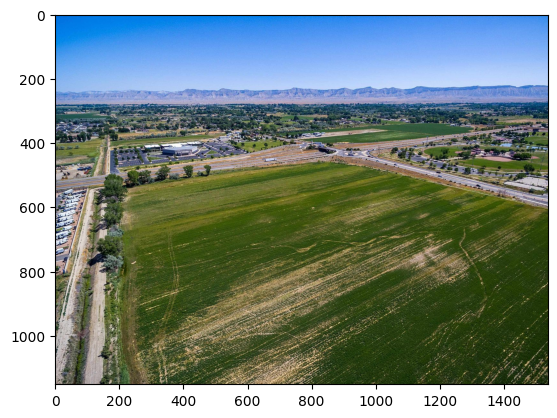

In [27]:
# Images from Creative Commons
# https://upload.wikimedia.org/wikipedia/commons/0/03/Lurie_Garden_%28Piet_Oudolf%29_-_Millennium_Park_-_Chicago_IL_%287833308160%29.jpg
# https://upload.wikimedia.org/wikipedia/commons/9/94/Adjoining_Industrial_Buildings_in_10-12-14_Ej%C3%A9rcito_Espa%C3%B1ol_street%2C_Valencia.jpg

inference_on_validation_data(inference_model=classifier, n_test_images=1)